<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 3: Scaling up (Food Vision Mini)

We've seen the power of tranfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 totoal classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data(using the power of deep learning)

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check wether we're using GPU.
!nvidia-smi

Mon Feb 24 06:04:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Creating helper functions.
In previous notebooks we've created a sreies of helper functions to do different task, let's download them.

In [2]:
# Get the helper functions.

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-02-24 06:04:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-24 06:04:40 (68.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import a series of helper functions to our notebook.
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data

# 101 Food classes: working with less data.

Our goal is to beat the original Food101 paper with 10% of the training data(using the power of deep learning)

The data we're downloading is from original Food101 dataset but has been process using the image_data_modifictions.

In [4]:
# Download and unzip the data.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


unzip_data("101_food_classes_10_percent.zip")

--2025-02-24 06:04:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   110MB/s    in 15s     

2025-02-24 06:05:03 (104 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# Setting up directories.
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
# How many images classes are they ?.

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 25

In [7]:
# Setup data inputs.

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
                              train_dir,
                              label_mode="categorical",
                              image_size=IMG_SIZE,
                              shuffle=True,
                            )

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
                              test_dir,
                              label_mode="categorical",
                              image_size=IMG_SIZE,
                              shuffle=False,      # Don't shuffle test datast for prediction analysis.
                            )



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes.

Here are the steps we're going to take:

* Create a ModelCheckpoint callback.
* Create a data augmentation layer to build data augmentation right into the model.
* Build headless (no top layers) Functional backboned-model (we'll create our own layer)
* Compile our model.
* Feature extract for 5 full passes (5 epochs on the train dataset).
                                                             

In [8]:
# Create checkpoint callback..

checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback =  tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,   # don't save whole model but only best.
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

In [9]:
# Create data augmentation layer to incorporate it right into the model.
from tensorflow.keras import layers
# from tensorflow.keras.layers import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomWidth(0.2),
  layers.RandomHeight(0.2),
  layers.RandomContrast(0.2),
  # preprocessing.Rescaling(1/255.)   $ REscale inputs of images b/t 0-1. required for models like ResNet50 since for EfficinetNet it already present
], name='data_augmentation')


### Building our Functional model architecture.

In [10]:
# Setup the base model and freeze its layers (This will extract features)

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze it since we're dealing with feature extraction.

# Setup model architecture with traniable top layers.
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(train_data_all_10_percent.element_spec[1].shape[-1], activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# How many trainable paramters are they ?.
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# Compile the model.
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model.
history_10_percent_data = model.fit(
    train_data_all_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 177ms/step - accuracy: 0.1604 - loss: 3.9423 - val_accuracy: 0.4282 - val_loss: 2.5502
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - accuracy: 0.4833 - loss: 2.3205 - val_accuracy: 0.4921 - val_loss: 2.0785
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.5587 - loss: 1.8946 - val_accuracy: 0.5191 - val_loss: 1.9059
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.5924 - loss: 1.6666 - val_accuracy: 0.5246 - val_loss: 1.8430
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.6257 - loss: 1.5200 - val_accuracy: 0.5485 - val_loss: 1.7318


In [13]:
# Evaluate the model.
model.evaluate(test_data_all_10_percent)

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.5603 - loss: 1.6713


[1.5886181592941284, 0.5828911066055298]

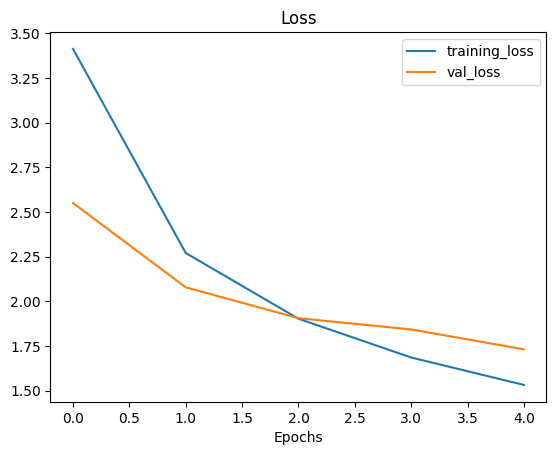

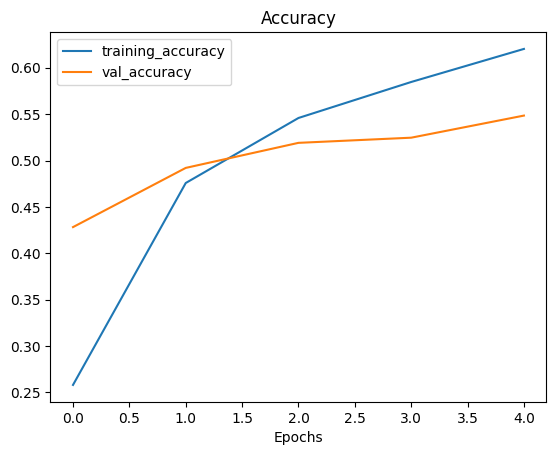

In [14]:
# plot loss curves.
plot_loss_curves(history_10_percent_data)

The two curves should be the same. But from the curves it shows that our model is **Overfitting** hence not being able to **Generalize** (performing too well on training data but not well on test data)

# Fine-tuning

In [15]:
# Unfreeze all of the layers in the base model.
base_model.trainable = True

# Refreeze.
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [16]:
# Recompile the model and lower learning rate.
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [17]:
# Which layers in the model are trianable.
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
# Check which layers are trainable.
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs
total_epochs

10

In [20]:
# Fit the model.
history_10_percent_data_fine_tune = model.fit(
    train_data_all_10_percent,
    epochs=total_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    initial_epoch=history_10_percent_data.epoch[-1],
    callbacks=[checkpoint_callback]
)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 58s 179ms/step - accuracy: 0.6297 - loss: 1.5055 - val_accuracy: 0.5538 - val_loss: 1.7069
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.6825 - loss: 1.2884 - val_accuracy: 0.5614 - val_loss: 1.6740
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.7012 - loss: 1.2142 - val_accuracy: 0.5702 - val_loss: 1.6260
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.7169 - loss: 1.1366 - val_accuracy: 0.5742 - val_loss: 1.6097
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.7253 - loss: 1.0783 - val_accuracy: 0.5800 - val_loss: 1.5884
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7364 - loss: 1.0519 - val_accuracy: 0.5765 - val_loss: 1.5831


In [ ]:
# evaluate the model.
model.evaluate(test_data_all_10_percent)

 26/790 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.3829 - loss: 2.1869

In [ ]:
# plot loss curves.
plot_loss_curves(history_10_percent_data_fine_tune)

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model.
compare_historys(
    original_history=history_10_percent_data_fine_tune,
    new_history=history_10_percent_data,
    initial_epochs=5
    )

## Saving and Loading our Model.

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuning model.
model.save("drive/MyDrive/101_food_classes_10_percent_data_model.keras")

In [ ]:
# Load and evaluate save model.
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_data_model.keras")

In [ ]:
loaded_model

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model.
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

## Evaluating the performance of the big dog model across all different classes.

Let's make some predictions, visualize them and then later find out which predictions where the 'most' wrong.

In [ ]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_all_data.zip

unzip_data("101_food_classes_all_data.zip")

In [ ]:
# Load the pretrained model.
model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_data_model.keras")
model

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

## Making predictions with our trained model

In [ ]:
# Make predictions with model.
preds_probs = model.predict(test_data, verbose=1)
preds_probs

In [ ]:
# How many predictions are there ?.
